<img style="float: left;padding: 1.3em" src="https://raw.githubusercontent.com/gw-odw/odw-2022/main/Tutorials/logo.png">  

#  Gravitational Wave Open Data Workshop #5


#### Tutorial 3.2: Parameter estimation on GW150914 using open data.

This example estimates the non-spinning parameters of the binary black hole system using
commonly used prior distributions. This will take about 40 minutes to run.
   
More examples at https://lscsoft.docs.ligo.org/bilby/examples.html

[Click this link to view this tutorial in Google Colaboratory](https://colab.research.google.com/github/gw-odw/odw-2022/blob/main/Tutorials/Day_3/Tuto_3.2_Parameter_estimation_for_compact_object_mergers.ipynb)


##  Installation  (execute only if running on a cloud platform!)

In [1]:
# -- Use the following line in Google Colab
! pip install -q lalsuite==6.82 bilby==1.0.4 gwpy==2.0.2 matplotlib==3.2.2 dynesty==1.0.0


**Important:** With Google Colab, you may need to restart the runtime after running the cell above.

## Initialization

We begin by importing some commonly used functions

In [2]:
%matplotlib inline
from __future__ import division, print_function
import numpy as np
import matplotlib.pyplot as plt

import bilby
from bilby.core.prior import Uniform
from bilby.gw.conversion import convert_to_lal_binary_black_hole_parameters, generate_all_bbh_parameters

from gwpy.timeseries import TimeSeries

# -- download data
! wget https://www.gw-openscience.org/s/workshop3/challenge/challenge3.gwf

--2022-05-30 15:31:33--  https://www.gw-openscience.org/s/workshop3/challenge/challenge3.gwf
Resolving www.gw-openscience.org (www.gw-openscience.org)... 131.215.113.73
Connecting to www.gw-openscience.org (www.gw-openscience.org)|131.215.113.73|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 256815066 (245M)
Saving to: ‘challenge3.gwf.1’

challenge3.gwf.1    100%[===================>] 244.92M  16.9MB/s    in 15s     

2022-05-30 15:31:49 (16.6 MB/s) - ‘challenge3.gwf.1’ saved [256815066/256815066]



## Bilby version

In [3]:
print(bilby.__version__)

1.0.4: release


## Getting the data: GW150914

In this notebook, we'll analyse GW150914. Our first task is to obtain some data!

We need to know the trigger time. This can be found on the [GWOSC page](https://www.gw-openscience.org/events/GW150914/), here we define it as a variable

In [4]:
time_of_event = 1126259462.4

### Set up empty interferometers

We need to get some data to analyse. We'll be using data from the Hanford (H1) and Livingston (L1) ground-based gravitational wave detectors. To organise ourselves, we'll create two "empty" interferometers. These are empty in the sense that they don't have any strain data. But, they know about the orientation and location of their respective namesakes. It may also be interesting to note that they are initialised with the planned design sensitivity power spectral density of advanced LIGO - we'll overwrite this later on, but it is often useful for simulations.

In [5]:
#H1 = bilby.gw.detector.get_empty_interferometer("H1")
#L1 = bilby.gw.detector.get_empty_interferometer("L1")

### Download the data

To analyse the signal, we need to download analysis data. Here, we will use [gwpy](https://gwpy.github.io/) to download the open strain data. For a general introduction to reading/writing data with gwpy, see [the documentation](https://gwpy.github.io/docs/stable/timeseries/).

To analyse GW150914, we will use a 4s period duration centered on the event itself. It is standard to choose the data such that it always includes a "post trigger duration" of 2s. That is, there is always 2s of data after the trigger time. We therefore define all times relative to the trigger time, duration and this post-trigger duration.

In [6]:
# Use gwpy to fetch the open data
sampling_rate=4096 
duration=1*4
start_time=1203.8

psd_duration = duration * 32
psd_start_time = start_time - psd_duration

H1=bilby.gw.detector.get_empty_interferometer('H1')
H1.set_strain_data_from_frame_file('challenge3.gwf',sampling_rate, duration, start_time=start_time ,channel='H1:CHALLENGE3')
L1=bilby.gw.detector.get_empty_interferometer('L1')
L1.set_strain_data_from_frame_file('challenge3.gwf',sampling_rate, duration, start_time=start_time ,channel='L1:CHALLENGE3')

15:31 bilby INFO    : Reading data from frame file challenge3.gwf
15:32 bilby INFO    : Successfully loaded H1:CHALLENGE3.
15:32 bilby INFO    : Reading data from frame file challenge3.gwf
15:32 bilby INFO    : Successfully loaded L1:CHALLENGE3.


### Download the power spectral data

Parameter estimation relies on having a power spectral density (PSD) - an estimate of the coloured noise properties of the data. Here, we will create a PSD using off-source data. For a review of methods to estimate PSDs, see, e.g. [Chatziioannou et al. (2019)](https://ui.adsabs.harvard.edu/abs/2019PhRvD.100j4004C/abstract).

Again, we need to download this from the open strain data. We start by figuring out the amount of data needed - in this case 32 times the analysis duration. We fetch the segment with this duration immediately preceding the analysis segment.

In [7]:
psd_duration = duration * 32
psd_start_time = time_of_event - psd_duration

H1_psd_data = TimeSeries.fetch_open_data(
    "H1", psd_start_time, psd_start_time + psd_duration, sample_rate=4096, cache=True)

L1_psd_data = TimeSeries.fetch_open_data(
    "L1", psd_start_time, psd_start_time + psd_duration, sample_rate=4096, cache=True)

Having obtained the data to generate the PSD, we now use the standard [gwpy psd](https://gwpy.github.io/docs/stable/api/gwpy.timeseries.TimeSeries/#gwpy.timeseries.TimeSeries.psd) method to calculate the PSD. Here, the `psd_alpha` variable is converting the `roll_off` applied to the strain data into the fractional value used by `gwpy`. This applies a window with an appropriate shape to the time-domain data.

In [8]:
psd_alpha = 2 * H1.strain_data.roll_off / duration
H1_psd = H1_psd_data.psd(fftlength=duration, overlap=0, window=("tukey", psd_alpha), method="median")
L1_psd = L1_psd_data.psd(fftlength=duration, overlap=0, window=("tukey", psd_alpha), method="median")

### Initialise the PSD
Now that we have PSDs for H1 and L1, we can overwrite the `power_spectal_density` attribute of our interferometers with a new PSD.

In [9]:
H1.power_spectral_density = bilby.gw.detector.PowerSpectralDensity(
    frequency_array=H1_psd.frequencies.value, psd_array=H1_psd.value)
L1.power_spectral_density = bilby.gw.detector.PowerSpectralDensity(
    frequency_array=H1_psd.frequencies.value, psd_array=L1_psd.value)

### Looking at the data
Okay, we have spent a bit of time now downloading and initializing things. Let's check that everything makes sense. To do this, we'll plot our analysis data alongside the amplitude spectral density (ASD); this is just the square root of the PSD and has the right units to be comparable to the frequency-domain strain data.

15:32 bilby INFO    : Generating frequency domain strain from given time domain strain.
15:32 bilby INFO    : Applying a tukey window with alpha=0.1, roll off=0.2


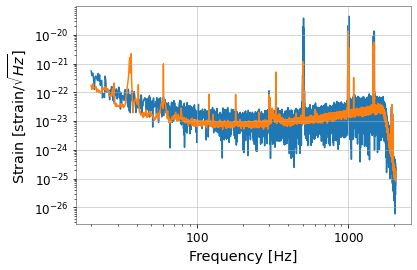

In [10]:
fig, ax = plt.subplots()
idxs = H1.strain_data.frequency_mask  # This is a boolean mask of the frequencies which we'll use in the analysis
ax.loglog(H1.strain_data.frequency_array[idxs],
          np.abs(H1.strain_data.frequency_domain_strain[idxs]))
ax.loglog(H1.power_spectral_density.frequency_array[idxs],
          H1.power_spectral_density.asd_array[idxs])
ax.set_xlabel("Frequency [Hz]")
ax.set_ylabel("Strain [strain/$\sqrt{Hz}$]")
plt.show()

What is happening at high frequencies? This is an artifact of the downsampling applied to the data - note that we downloaded the 4096Hz data which is downsampled from 16384Hz. We aren't really interested in the data at these high frequencies so let's adjust the maximum frequency used in the analysis to 1024 Hz and plot things again.

In [11]:
H1.maximum_frequency = 1024
L1.maximum_frequency = 1024

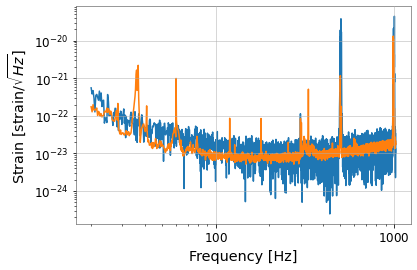

In [12]:
fig, ax = plt.subplots()
idxs = H1.strain_data.frequency_mask
ax.loglog(H1.strain_data.frequency_array[idxs],
          np.abs(H1.strain_data.frequency_domain_strain[idxs]))
ax.loglog(H1.power_spectral_density.frequency_array[idxs],
          H1.power_spectral_density.asd_array[idxs])
ax.set_xlabel("Frequency [Hz]")
ax.set_ylabel("Strain [strain/$\sqrt{Hz}$]")
plt.show()

Okay, that is better - we now won't analyse any data near to the artifact produced by downsampling. Now we have some sensible data to analyse so let's get right on with doing the analysis!

## Low dimensional analysis

In general a compact binary coalescence signal is described by 15 parameters describing the masses, spins, orientation, and position of the two compact objects along with a time at which the signal merges. The goal of parameter estimation is to figure out what the data (and any cogent prior information) can tell us about the likely values of these parameters - this is called the "posterior distribution of the parameters".

To start with, we'll analyse the data fixing all but a few of the parameters to known values (in Bayesian lingo - we use delta function priors), this will enable us to run things in a few minutes rather than the many hours needed to do full parameter estimation.

We'll start by thinking about the mass of the system. We call the heavier black hole the primary and label its mass $m_1$ and that of the secondary (lighter) black hole $m_2$. In this way, we always define $m_1 \ge m_2$. It turns out that inferences about $m_1$ and $m_2$ are highly correlated, we'll see exactly what this means later on.

Bayesian inference methods are powerful at figuring out highly correlated posteriors. But, we can help it along by sampling in parameters which are not highly correlated. In particular, we define a new parameter called the [chirp mass](https://en.wikipedia.org/wiki/Chirp_mass) to be

$$ \mathcal{M} = \frac{(m_1 m_2)^{3/5}}{(m_1 + m_2)^{1/5}} $$

and the mass ratio

$$ q = \frac{m_{2}}{m_1} $$

If we sample (make inferences about) $\mathcal{M}$ and $q$, our code is much faster than if we use $m_1$ and $m_2$ directly! Note that so long as equivalent prior is given - one can also sample in the component masses themselves and you will get the same answer, it is just much slower!

Once we have inferred $\mathcal{M}$ and $q$, we can then derive $m_1$ and $m_2$ from the resulting samples (we'll do that in just a moment).

Okay, let's run a short (~1min on a single 2.8GHz core), low-dimensional parameter estimation analysis. This is done by defining a prior dictionary where all parameters are fixed, except those that we want to vary.

### Create a prior

Here, we create a prior fixing everything except the chirp mass, mass ratio, phase and geocent_time parameters to fixed values. The first two were described above. The second two give the phase of the system and the time at which it merges.

In [17]:
prior = bilby.core.prior.PriorDict()
prior['chirp_mass'] = Uniform(name='chirp_mass', minimum=30.0,maximum=32.5)
prior['mass_ratio'] = Uniform(name='mass_ratio', minimum=0.5, maximum=1)
prior['phase'] = Uniform(name="phase", minimum=0, maximum=2*np.pi)
prior['geocent_time'] = Uniform(name="geocent_time", minimum=start_time-0.1, maximum=start_time + duration +0.1)
prior['a_1'] =  0.0
prior['a_2'] =  0.0
prior['tilt_1'] =  0.0
prior['tilt_2'] =  0.0
prior['phi_12'] =  0.0
prior['phi_jl'] =  0.0
prior['dec'] =  -1.2232
prior['ra'] =  2.19432
prior['theta_jn'] =  1.89694
prior['psi'] =  0.532268
prior['luminosity_distance'] = 412.066


## Create a likelihood

For Bayesian inference, we need to evaluate the likelihood. In Bilby, we create a likelihood object. This is the communication interface between the sampling part of Bilby and the data. Explicitly, when Bilby is sampling it only uses the `parameters` and `log_likelihood()` of the likelihood object. This means the likelihood can be arbitrarily complicated and the sampling part of Bilby won't mind a bit!

Let's create a `GravitationalWaveTransient`, a special inbuilt method carefully designed to wrap up evaluating the likelihood of a waveform model in some data.

In [18]:
# First, put our "data" created above into a list of interferometers (the order is arbitrary)
interferometers = [H1, L1]

# Next create a dictionary of arguments which we pass into the LALSimulation waveform - we specify the waveform approximant here
waveform_arguments = dict(
    waveform_approximant='IMRPhenomPv2', reference_frequency=100., catch_waveform_errors=True)

# Next, create a waveform_generator object. This wraps up some of the jobs of converting between parameters etc
waveform_generator = bilby.gw.WaveformGenerator(
    frequency_domain_source_model=bilby.gw.source.lal_binary_black_hole,
    waveform_arguments=waveform_arguments,
    parameter_conversion=convert_to_lal_binary_black_hole_parameters)

# Finally, create our likelihood, passing in what is needed to get going
likelihood = bilby.gw.likelihood.GravitationalWaveTransient(
    interferometers, waveform_generator, priors=prior,
    time_marginalization=True, phase_marginalization=True, distance_marginalization=False)

15:36 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


Note that we also specify `time_marginalization=True` and `phase_marginalization=True`. This is a trick often used in Bayesian inference. We analytically marginalize (integrate) over the time/phase of the system while sampling, effectively reducing the parameter space and making it easier to sample. Bilby will then figure out (after the sampling) posteriors for these marginalized parameters. For an introduction to this topic, see [Thrane & Talbot (2019)](https://arxiv.org/abs/1809.02293).

In [19]:
ifo_index = 0
idxs = interferometers[ifo_index].strain_data.frequency_mask
print(interferometers[ifo_index].strain_data.frequency_array[idxs])
print(np.abs(interferometers[ifo_index].strain_data.frequency_domain_strain[idxs]))
print(interferometers[ifo_index].power_spectral_density.frequency_array[idxs])
print(np.abs(interferometers[ifo_index].power_spectral_density.asd_array[idxs]))
print(len(interferometers[ifo_index].strain_data.frequency_domain_strain[idxs]))


[  20.     20.25   20.5  ... 1023.5  1023.75 1024.  ]
[5.55535213e-22 3.82394363e-22 4.68678143e-22 ... 2.27890732e-24
 2.16342611e-23 1.31518706e-23]
[  20.     20.25   20.5  ... 1023.5  1023.75 1024.  ]
[1.74486099e-22 1.27822074e-22 1.98055876e-22 ... 2.01481430e-23
 2.17244237e-23 1.82386692e-23]
4017


### Run the analysis

Now that the prior is set-up and the likelihood is set-up (with the data and the signal mode), we can run the sampler to get the posterior result. This function takes the likelihood and prior along with some options for how to do the sampling and how to save the data.

In [20]:
result_short = bilby.run_sampler(
    likelihood, prior, sampler='dynesty', outdir='short', label="GW150914",
    conversion_function=bilby.gw.conversion.generate_all_bbh_parameters,
    sample="unif", nlive=500, dlogz=3  # <- Arguments are used to make things fast - not recommended for general use
)

15:36 bilby INFO    : Running for label 'GW150914', output will be saved to 'short'
15:36 bilby INFO    : Using lal version 7.1.2
15:36 bilby INFO    : Using lal git version Branch: None;Tag: lalsuite-v6.82;Id: cf792129c2473f42ce6c6ee21d8234254cefd337;;Builder: Unknown User <>;Repository status: UNCLEAN: Modified working tree
15:36 bilby INFO    : Using lalsimulation version 2.5.1
15:36 bilby INFO    : Using lalsimulation git version Branch: None;Tag: lalsuite-v6.82;Id: cf792129c2473f42ce6c6ee21d8234254cefd337;;Builder: Unknown User <>;Repository status: UNCLEAN: Modified working tree
15:36 bilby INFO    : Search parameters:
15:36 bilby INFO    :   chirp_mass = Uniform(minimum=30.0, maximum=32.5, name='chirp_mass', latex_label='$\\mathcal{M}$', unit=None, boundary=None)
15:36 bilby INFO    :   mass_ratio = Uniform(minimum=0.5, maximum=1, name='mass_ratio', latex_label='$q$', unit=None, boundary=None)
15:36 bilby INFO    :   time_jitter = Uniform(minimum=-0.000244140625, maximum=0.00024


0it [00:00, ?it/s]

15:36 bilby INFO    : Using sampler Dynesty with kwargs {'bound': 'multi', 'sample': 'unif', 'verbose': True, 'periodic': None, 'reflective': None, 'check_point_delta_t': 600, 'nlive': 500, 'first_update': None, 'walks': 100, 'npdim': None, 'rstate': None, 'queue_size': 1, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': None, 'ptform_kwargs': None, 'enlarge': 1.5, 'bootstrap': None, 'vol_dec': 0.5, 'vol_check': 8.0, 'facc': 0.2, 'slices': 5, 'update_interval': 300, 'print_func': <bound method Dynesty._print_func of <bilby.core.sampler.dynesty.Dynesty object at 0x7f0424d3f8d0>>, 'dlogz': 3, 'maxiter': None, 'maxcall': None, 'logl_max': inf, 'add_live': True, 'print_progress': True, 'save_bounds': False, 'n_effective': None, 'maxmcmc': 5000, 'nact': 5}
15:36 bilby INFO    : Checkpoint every check_point_delta_t = 600s
15:36 bilby INFO    : Using dynesty version 1.0.0
15:36 bilby INFO    : Resume file short/GW150914_resume.pickle 


1it [00:10, 10.65s/it, bound:0 nc:  1 ncall:5.0e+02 eff:0.2% logz-ratio=217.22+/-0.17 dlogz:inf>3]
7it [00:10,  1.13s/it, bound:0 nc:  1 ncall:5.1e+02 eff:1.4% logz-ratio=221.58+/-0.14 dlogz:34.503>3]
13it [00:10,  1.97it/s, bound:0 nc:  1 ncall:5.1e+02 eff:2.5% logz-ratio=223.52+/-0.13 dlogz:32.461>3]
19it [00:11,  3.45it/s, bound:0 nc:  1 ncall:5.2e+02 eff:3.7% logz-ratio=224.71+/-0.12 dlogz:31.189>3]
25it [00:11,  5.42it/s, bound:0 nc:  1 ncall:5.3e+02 eff:4.8% logz-ratio=225.99+/-0.12 dlogz:29.903>3]
31it [00:11,  7.98it/s, bound:0 nc:  1 ncall:5.3e+02 eff:5.8% logz-ratio=227.05+/-0.12 dlogz:28.844>3]
37it [00:11, 11.22it/s, bound:0 nc:  1 ncall:5.4e+02 eff:6.9% logz-ratio=228.20+/-0.12 dlogz:27.692>3]
43it [00:11, 15.06it/s, bound:0 nc:  1 ncall:5.4e+02 eff:7.9% logz-ratio=229.40+/-0.12 dlogz:26.491>3]
49it [00:11, 19.15it/s, bound:0 nc:  1 ncall:5.5e+02 eff:8.9% logz-ratio=230.38+/-0.12 dlogz:25.405>3]
55it [00:11, 23.43it/s, bound:0 nc:  1 ncall:5.6e+02 eff:9.9% logz-ratio=231.

15:37 bilby INFO    : Written checkpoint file short/GW150914_resume.pickle
15:37 bilby INFO    : Writing 227 current samples to short/GW150914_samples.dat
/usr/local/lib/python3.7/dist-packages/dynesty/utils.py:143: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  idx = np.zeros(nsamples, dtype=np.int)
/usr/local/lib/python3.7/dist-packages/dynesty/utils.py:143: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `n

846it [00:51, 16.29it/s, bound:0 nc:  1 ncall:2.7e+03 eff:49.8% logz-ratio=253.31+/-0.07 dlogz:0.004>3]

/usr/local/lib/python3.7/dist-packages/dynesty/utils.py:143: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  idx = np.zeros(nsamples, dtype=np.int)
15:37 bilby INFO    : Sampling time: 0:00:38.544594
/usr/local/lib/python3.7/dist-packages/bilby/core/result.py:1294: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  if "npool" in inspect.getargspec(conversion_function).args:
15:37 bilby INFO    : Reconstructing marginalised parameters.





  0%|          | 0/1346 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/bilby/gw/source.py:384: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  h_plus = np.zeros_like(frequency_array, dtype=np.complex)
/usr/local/lib/python3.7/dist-packages/bilby/gw/source.py:385: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  h_cross = np.zeros_like(frequency_array, dtype


100%|██████████| 1346/1346 [04:38<00:00,  4.83it/s]

15:42 bilby INFO    : Generating sky frame parameters.




100%|██████████| 1346/1346 [00:00<00:00, 2368.12it/s]


15:42 bilby INFO    : Computing SNRs for every sample.



100%|██████████| 1346/1346 [00:23<00:00, 56.72it/s]


15:42 bilby INFO    : Summary of results:
nsamples: 1346
ln_noise_evidence: -2980052.045
ln_evidence: -2979798.730 +/-  0.068
ln_bayes_factor: 253.314 +/-  0.068



### Looking at the outputs

The `run_sampler` returned `result_short` - this is a Bilby result object. The posterior samples are stored in a [pandas data frame](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html) (think of this like a spreadsheet); let's take a look at it

In [21]:
result_short.posterior

,chirp_mass,mass_ratio,time_jitter,phase,geocent_time,a_1,a_2,tilt_1,tilt_2,phi_12,...,redshift,comoving_distance,mass_1_source,mass_2_source,chirp_mass_source,total_mass_source,H1_matched_filter_snr,H1_optimal_snr,L1_matched_filter_snr,L1_optimal_snr
0,30.593809,0.760404,-0.000243,6.024469,1204.689599,0.0,0.0,0.0,0.0,0.0,...,0.087423,378.938181,37.130521,28.234187,28.134236,65.364708,28.017625+3.675067j,10.154600,7.658408-7.266579j,7.093831
1,32.274491,0.750494,0.000131,5.560018,1204.688944,0.0,0.0,0.0,0.0,0.0,...,0.087423,378.938181,39.435265,29.595931,29.679801,69.031196,27.510733+1.893133j,10.605950,7.201036-6.896119j,7.391058
2,31.890839,0.742878,-0.000048,2.502707,1204.689174,0.0,0.0,0.0,0.0,0.0,...,0.087423,378.938181,39.171521,29.099660,29.326992,68.271181,27.664907+3.683274j,10.493898,7.436395-6.731069j,7.316038
3,31.089906,0.739721,-0.000031,5.724329,1204.689334,0.0,0.0,0.0,0.0,0.0,...,0.087423,378.938181,38.271552,28.310279,28.590450,66.581832,27.118141+7.188616j,10.271799,8.689722-5.975913j,7.168860
4,31.871603,0.749238,-0.000063,2.427198,1204.689011,0.0,0.0,0.0,0.0,0.0,...,0.087423,378.938181,38.976559,29.202706,29.309303,68.179265,27.161492+4.943314j,10.495356,8.216993-6.261701j,7.317720
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1341,31.651168,0.987013,-0.000221,2.913323,1204.689297,0.0,0.0,0.0,0.0,0.0,...,0.087423,378.938181,33.654090,33.217008,29.106590,66.871098,27.431794+4.204149j,10.544189,8.328175-6.886754j,7.362586
1342,31.651168,0.987013,-0.000221,2.973278,1204.689567,0.0,0.0,0.0,0.0,0.0,...,0.087423,378.938181,33.654090,33.217008,29.106590,66.871098,27.166185+7.707102j,10.544189,8.543376-6.073546j,7.362586
1343,31.651168,0.987013,-0.000221,6.037271,1204.689486,0.0,0.0,0.0,0.0,0.0,...,0.087423,378.938181,33.654090,33.217008,29.106590,66.871098,26.331898+9.854726j,10.544189,9.189989-5.262145j,7.362586
1344,31.651168,0.987013,-0.000221,6.131040,1204.689403,0.0,0.0,0.0,0.0,0.0,...,0.087423,378.938181,33.654090,33.217008,29.106590,66.871098,27.841520+2.679557j,10.544189,7.701633-7.414317j,7.362586


We can pull out specific parameters that we are interested in

In [22]:
result_short.posterior["chirp_mass"]

0       30.593809
1       32.274491
2       31.890839
3       31.089906
4       31.871603
          ...    
1341    31.651168
1342    31.651168
1343    31.651168
1344    31.651168
1345    31.651168
Name: chirp_mass, Length: 1346, dtype: float64

This returned another `pandas` object. If you just want to get the numbers as a numpy array run

In [23]:
Mc = result_short.posterior["chirp_mass"].values

We can then get some useful quantities such as the 90\% credible interval

In [24]:
lower_bound = np.quantile(Mc, 0.05)
upper_bound = np.quantile(Mc, 0.95)
median = np.quantile(Mc, 0.5)
print("Mc = {} with a 90% C.I = {} -> {}".format(median, lower_bound, upper_bound))

Mc = 31.63065796480537 with a 90% C.I = 30.991677573398732 -> 32.343736812549274


We can then plot the chirp mass in a histogram adding a region to indicate the 90\% C.I.

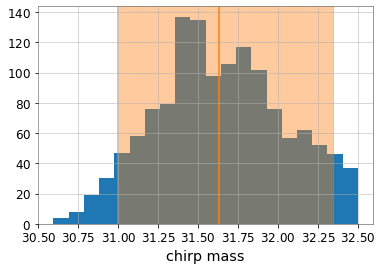

In [25]:
fig, ax = plt.subplots()
ax.hist(result_short.posterior["chirp_mass"], bins=20)
ax.axvspan(lower_bound, upper_bound, color='C1', alpha=0.4)
ax.axvline(median, color='C1')
ax.set_xlabel("chirp mass")
plt.show()

The result object also has in-built methods to make nice plots such as corner plots. You can add the priors if you are only plotting parameters which you sampled in, e.g.

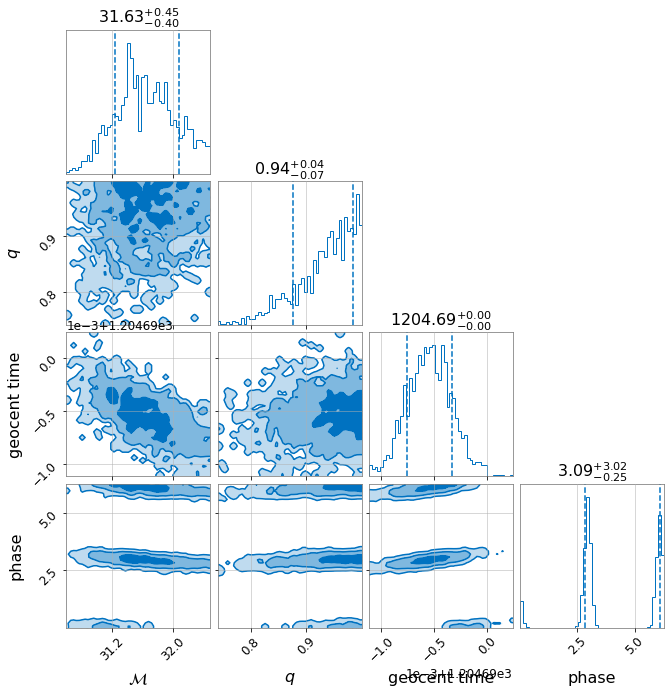

In [26]:
result_short.plot_corner(parameters=["chirp_mass", "mass_ratio", "geocent_time", "phase"], prior=True)

You can also plot lines indicating specific points. Here, we add the values recorded on [GWOSC](https://www.gw-openscience.org/events/GW150914/). Notably, these fall outside the bulk of the posterior uncertainty here. This is because we limited our prior - if instead we ran the full analysis these agree nicely.

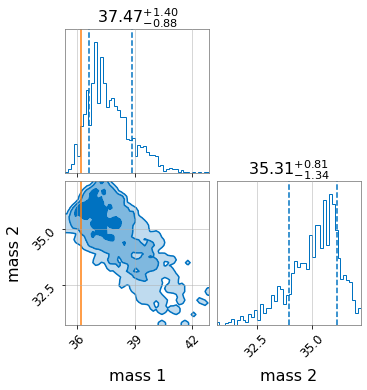

In [27]:
parameters = dict(mass_1=36.2, mass_2=29.1)
result_short.plot_corner(parameters)

Earlier we discussed the "correlation" - in this plot we start to see the correlation between $m_1$ and $m_2$.

### Meta data
The result object also stores meta data, like the priors

In [28]:
result_short.priors

{'a_1': DeltaFunction(peak=0.0, name=None, latex_label=None, unit=None),
 'a_2': DeltaFunction(peak=0.0, name=None, latex_label=None, unit=None),
 'chirp_mass': Uniform(minimum=30.0, maximum=32.5, name='chirp_mass', latex_label='$\\mathcal{M}$', unit=None, boundary=None),
 'dec': DeltaFunction(peak=-1.2232, name=None, latex_label=None, unit=None),
 'geocent_time': Uniform(minimum=1203.7, maximum=1207.8999999999999, name='geocent_time', latex_label='$t_c$', unit=None, boundary=None),
 'luminosity_distance': DeltaFunction(peak=412.066, name=None, latex_label=None, unit=None),
 'mass_ratio': Uniform(minimum=0.5, maximum=1, name='mass_ratio', latex_label='$q$', unit=None, boundary=None),
 'phase': Uniform(minimum=0, maximum=6.283185307179586, name='phase', latex_label='$\\phi$', unit=None, boundary=None),
 'phi_12': DeltaFunction(peak=0.0, name=None, latex_label=None, unit=None),
 'phi_jl': DeltaFunction(peak=0.0, name=None, latex_label=None, unit=None),
 'psi': DeltaFunction(peak=0.532268

and details of the analysis itself:

In [29]:
result_short.sampler_kwargs["nlive"]

500

Finally, we can also get out the Bayes factor for the signal vs. Gaussian noise. This quantifies the probability that the analyzed segment contains a binary black hole signal compared to just containing noise.

In [30]:
print("ln Bayes factor = {} +/- {}".format(
    result_short.log_bayes_factor, result_short.log_evidence_err))

ln Bayes factor = 253.3144744350432 +/- 0.06776201959385017


## Challenge questions
First, let's take a closer look at the result obtained with the run above. What are the means of the chirp mass and mass ratio distributions? What are the medians of the distributions for the components masses? You can use `np.mean` and `np.median` to calculate these.

Now let's expand on this example a bit. Rerun the analysis above but change the prior on the distance from a delta function to `bilby.core.prior.PowerLaw(alpha=2., minimum=50., maximum=800., name='luminosity_distance')`. You should also replace `sample='unif'` with `sample="rwalk", nact=1, walks=1` in your call to `bilby.run_sampler` above. This will take a bit longer than the original run, around ~20 minutes. You also need to change the `label` in the call to `run_sampler` to avoid over-writing your results.

What is the median reported value of the distance posterior? What is the new log Bayes factor for signal vs. Gaussian noise? Don't be alarmed if your results do not match the official LVC results, as these are not rigorous settings.

# Means and medians of the chirp mass and mass ratio

In [31]:
m_chirp = result_short.posterior["chirp_mass"]
q = result_short.posterior["mass_ratio"]
print("chirp mass mean",np.mean(m_chirp))
print("mass ratio mean",np.mean(q))
print("chirp mass median",np.median(m_chirp))
print("mass ratio median",np.median(q))

chirp mass mean 31.643704061411274
mass ratio mean 0.9321476613622544
chirp mass median 31.63065796480537
mass ratio median 0.9442507516295188
